In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Importing all necessary modules & packages 

# For Data Analysis , Sampling & Visualization
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# For Model Building Training and Preliminary Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
import sklearn.metrics 



In [3]:
# Read in the train and test data
train_df = pd.read_csv("/kaggle/input/parkinsons-training-data-subset/subset_data.csv")
test_df = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/defog/02ab235146.csv")

train_df.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,96674,-1.357992,0.291413,-0.135973,0,0,0,True,True
1,67983,-1.009866,-0.007781,0.190660,0,0,0,False,False
2,77983,-0.818155,0.091926,0.589086,0,0,0,False,False
3,91827,-0.754221,0.401860,-0.050428,0,0,0,True,True
4,96878,-0.892953,-0.213519,-0.339437,0,0,0,True,True


### Quick Statistical Exploration

In [4]:
# Training dataset
train_df.describe()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
count,6.762836e+06,6.762836e+06,6.762836e+06,6.762836e+06,6.762836e+06,6.762836e+06,6.762836e+06
mean,8.661045e+04,-9.401417e-01,1.152158e-03,-1.305603e-01,3.548807e-05,4.199806e-02,6.836629e-03
std,6.478337e+04,8.607013e-02,1.199816e-01,2.824377e-01,5.957081e-03,2.005847e-01,8.240079e-02
min,0.000000e+00,-6.024701e+00,-3.665250e+00,-5.118650e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.727100e+04,-9.865558e-01,-6.250000e-02,-3.125000e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.516700e+04,-9.531250e-01,2.356836e-03,-1.819980e-01,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.211540e+05,-9.062500e-01,7.812500e-02,3.125000e-02,0.000000e+00,0.000000e+00,0.000000e+00
max,4.153860e+05,4.458365e+00,3.231641e+00,3.985749e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [5]:
# The Test dataset
test_df.describe()

,Time,AccV,AccML,AccAP
count,281688.000000,281688.000000,281688.000000,281688.000000
mean,140843.500000,-0.941659,-0.039638,-0.018274
std,81316.465651,0.072058,0.146271,0.271586
min,0.000000,-2.416703,-1.083721,-1.089635
25%,70421.750000,-0.981812,-0.207627,-0.218777
50%,140843.500000,-0.953466,0.004935,-0.087531
75%,211265.250000,-0.899321,0.069483,0.242827
max,281687.000000,0.536504,0.738959,1.037056


In [6]:
# Variable types of the dataframe
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6762836 entries, 0 to 6762835
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Time             int64  
 1   AccV             float64
 2   AccML            float64
 3   AccAP            float64
 4   StartHesitation  int64  
 5   Turn             int64  
 6   Walking          int64  
 7   Valid            bool   
 8   Task             bool   
dtypes: bool(2), float64(3), int64(4)
memory usage: 374.1 MB


In [7]:
# Checking for null values
train_df.isnull().sum()

Time               0
AccV               0
AccML              0
AccAP              0
StartHesitation    0
Turn               0
Walking            0
Valid              0
Task               0
dtype: int64

## Exploratory Data Visualization

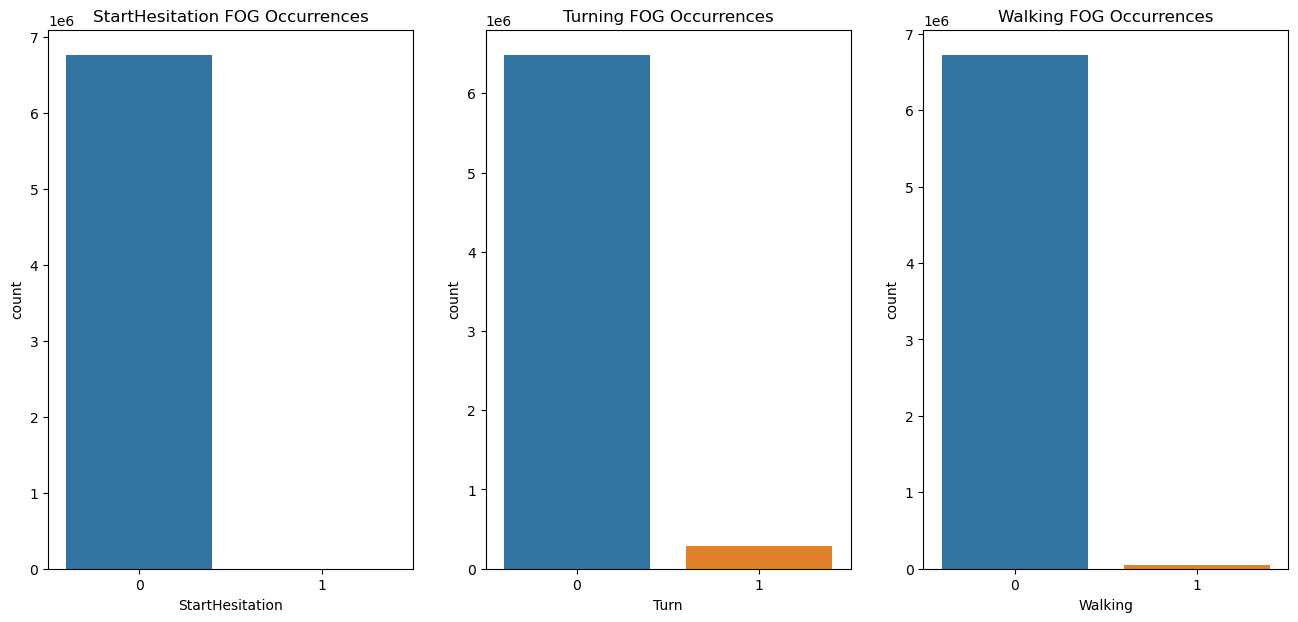

<Figure size 640x480 with 0 Axes>

In [8]:
# Countplots of the 3 different FOG events
plt.figure(figsize = (16, 7))
plt.subplot(1,3,1)
sns.countplot(train_df, x = "StartHesitation")
plt.title('StartHesitation FOG Occurrences')

plt.subplot(1,3,2)
sns.countplot(train_df, x = "Turn")
plt.title('Turning FOG Occurrences')

plt.subplot(1,3,3)
sns.countplot(train_df, x = "Walking")
plt.title('Walking FOG Occurrences')
plt.show()
plt.tight_layout()

#### Filtering the training data to only include series where labellings of the FOG event was valid

In [9]:
train_df = train_df[train_df["Valid"] == True]
train_df.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,96674,-1.357992,0.291413,-0.135973,0,0,0,True,True
3,91827,-0.754221,0.401860,-0.050428,0,0,0,True,True
4,96878,-0.892953,-0.213519,-0.339437,0,0,0,True,True
5,71469,-0.854042,-0.052418,0.075148,0,0,0,True,True
6,18301,-0.993596,-0.134030,-0.020922,0,0,0,True,True


#### Explicitly  Viewing the Relative Distribution of FOG event occurences (only valid)

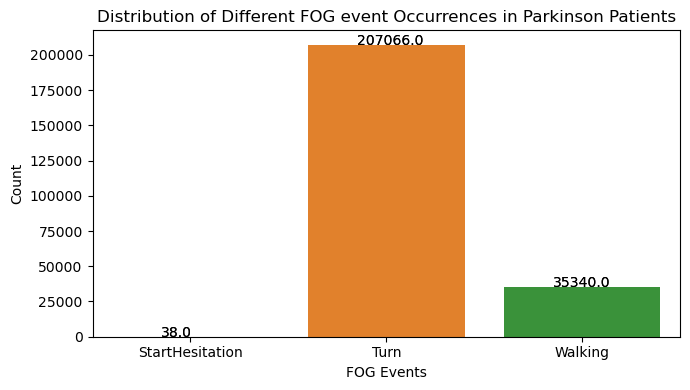

In [10]:
fog_occurrences = [train_df["StartHesitation"].value_counts()[1], train_df["Turn"].value_counts()[1], train_df["Walking"].value_counts()[1]]
temp_df = pd.DataFrame({
    "FOG Events": "StartHesitation Turn Walking".split(),
    "Count": fog_occurrences
})

# Plotting
plt.rcParams["figure.figsize"] = [7.00, 4]

sns.barplot(data = temp_df, x = "FOG Events", y = "Count")
ax = sns.barplot(data = temp_df, x = "FOG Events", y = "Count")

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+2.0))

    
plt.title("Distribution of Different FOG event Occurrences in Parkinson Patients")
plt.tight_layout()
plt.show()

# NOTE: See how StartHesitation was the most difficult to have labelled!!

#### Inlight of needing enough data for training the models, we cannot filter to only include unambiguous records but must instead include all and allow the model to train. 
(An acute Bias-Variance Trade off decision)

In [11]:
# Resetting the trainind data
train_df = pd.read_csv("/kaggle/input/parkinsons-training-data-subset/subset_data.csv")

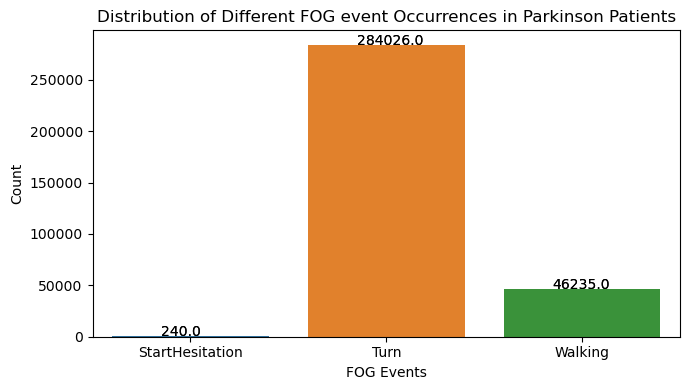

In [12]:
# Explicitly  Viewing the relative distribution of FOG event occurences
fog_occurrences = [train_df["StartHesitation"].value_counts()[1], train_df["Turn"].value_counts()[1], train_df["Walking"].value_counts()[1]]
temp_df = pd.DataFrame({
    "FOG Events": "StartHesitation Turn Walking".split(),
    "Count": fog_occurrences
})

# Plotting
plt.rcParams["figure.figsize"] = [7.00, 4]

sns.barplot(data = temp_df, x = "FOG Events", y = "Count")
ax = sns.barplot(data = temp_df, x = "FOG Events", y = "Count")

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+2.0))

    
plt.title("Distribution of Different FOG event Occurrences in Parkinson Patients")
plt.tight_layout()
plt.show()

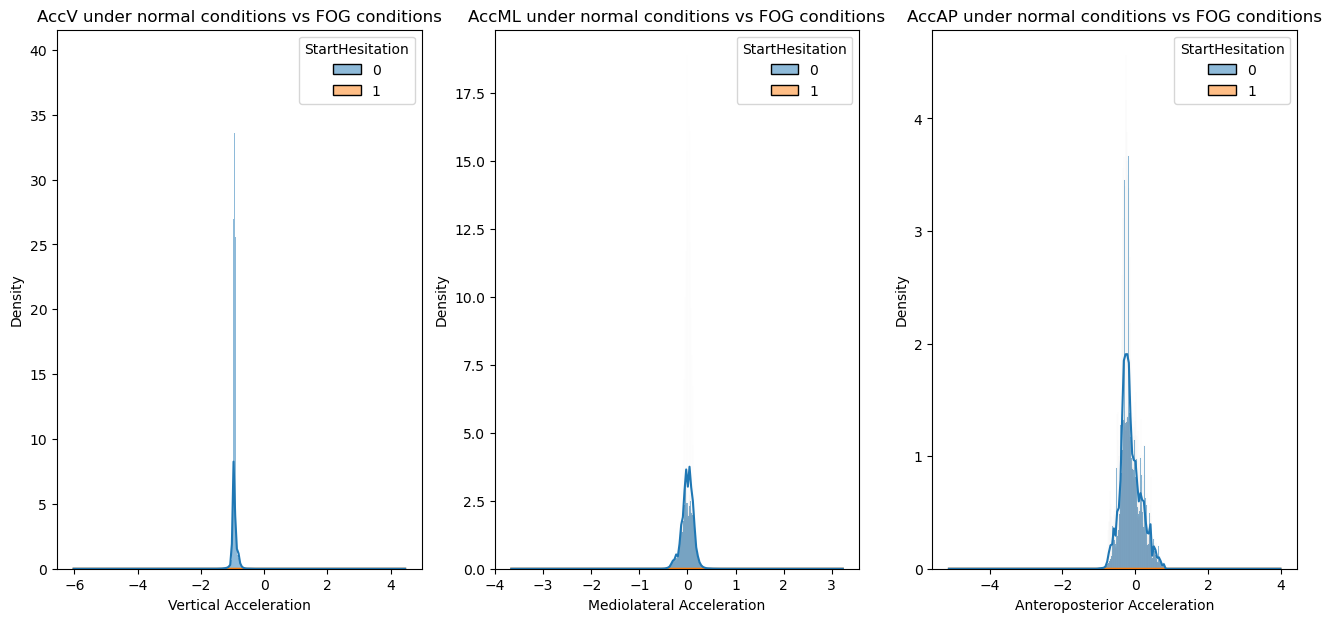

In [13]:
# Distribution of sensor recorded acceleration values as categorized in patients experiencing StartHesitation-FOG
# NOTE: As the classes are imablanced comparing distributions in terms of counts is not ideal so we intead normalize the data by use of the stat parameter

plt.figure(figsize = (16, 7))
plt.subplot(1,3,1)
sns.histplot(train_df, x = 'AccV', hue = 'StartHesitation', stat = 'density', fill = True, kde = True)
plt.xlabel('Vertical Acceleration')
plt.title('AccV under normal conditions vs FOG conditions')
# plt.ylim(0, 20)

plt.subplot(1,3,2)
sns.histplot(train_df, x = "AccML", hue = 'StartHesitation', stat = 'density', fill = True, kde = True)
plt.xlabel('Mediolateral Acceleration')
plt.title('AccML under normal conditions vs FOG conditions')

plt.subplot(1,3,3)
sns.histplot(train_df, x = "AccAP", hue = 'StartHesitation', stat = 'density', fill = True, kde = True)
plt.xlabel('Anteroposterior Acceleration')
plt.title('AccAP under normal conditions vs FOG conditions')
plt.show()



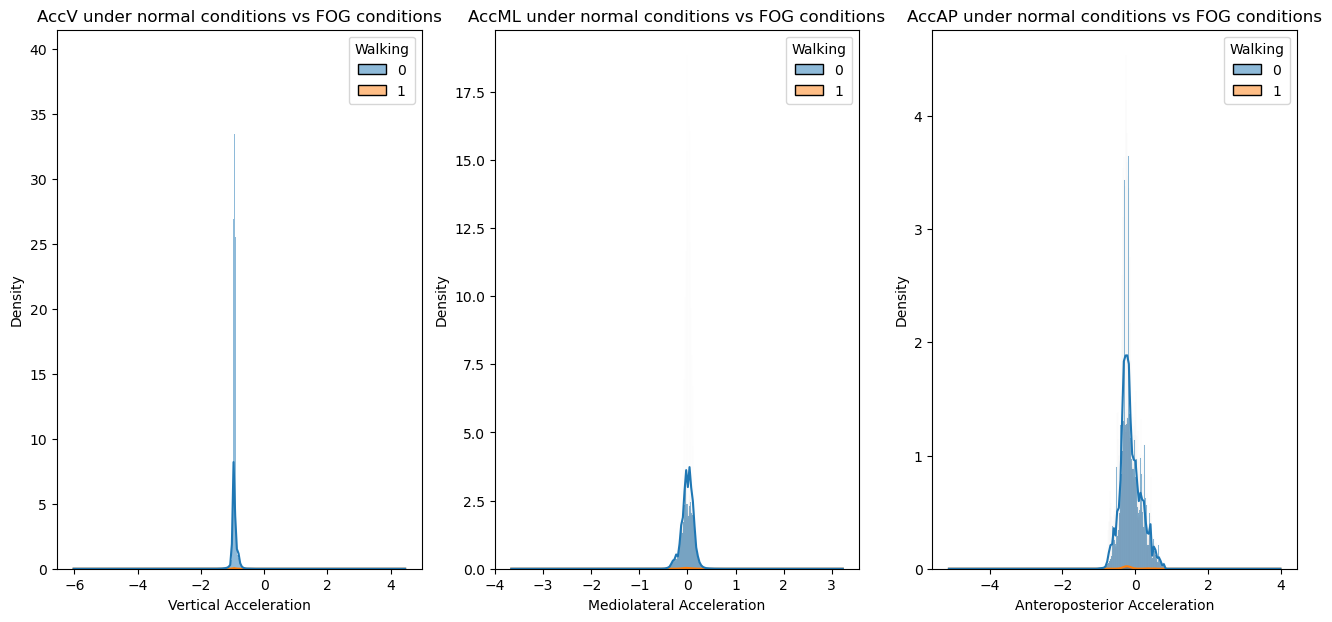

In [14]:
# Distribution of sensor recorded acceleration values as categorized in patients experiencing Walking-FOG

plt.figure(figsize = (16, 7))
plt.subplot(1,3,1)
sns.histplot(train_df, x = 'AccV', hue = 'Walking', stat = 'density', fill = True, kde = True)
plt.xlabel('Vertical Acceleration')
plt.title('AccV under normal conditions vs FOG conditions')

plt.subplot(1,3,2)
sns.histplot(train_df, x = "AccML", hue = 'Walking', stat = 'density', fill = True,kde = True)
plt.xlabel('Mediolateral Acceleration')
plt.title('AccML under normal conditions vs FOG conditions')

plt.subplot(1,3,3)
sns.histplot(train_df, x = "AccAP", hue = 'Walking', stat = 'density', fill = True,kde = True)
plt.xlabel('Anteroposterior Acceleration')
plt.title('AccAP under normal conditions vs FOG conditions')
plt.show()


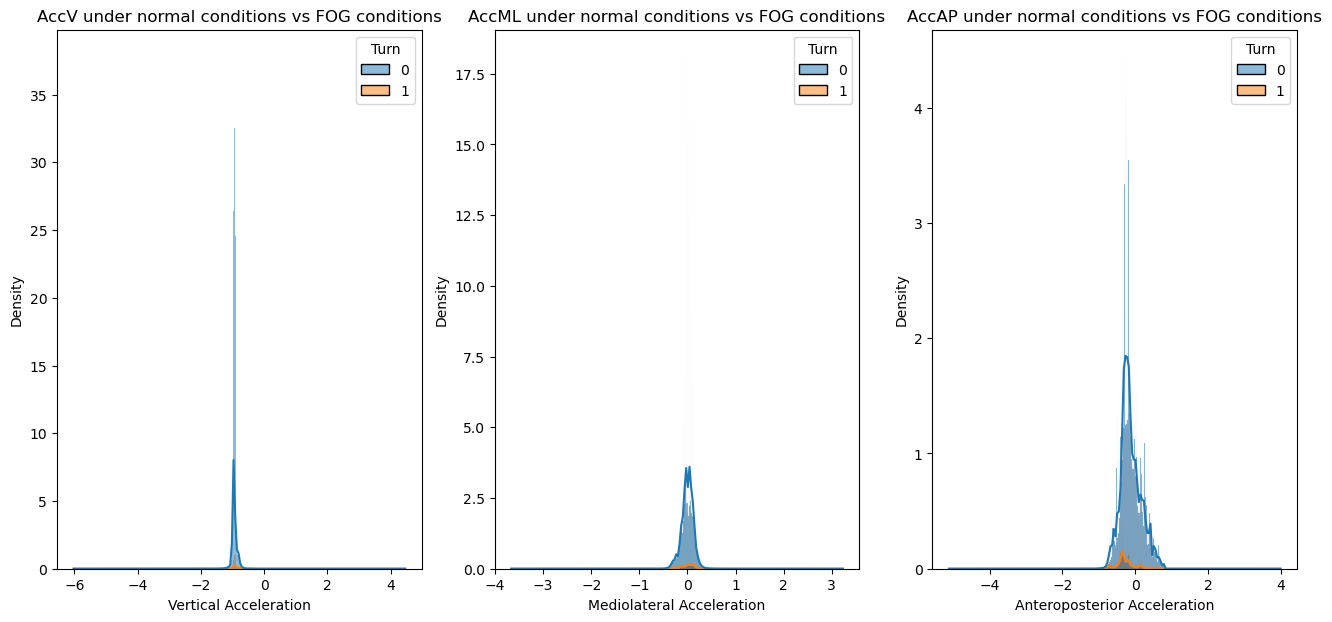

In [15]:
# Distribution of sensor recorded acceleration values as categorized in patients experiencing Turn-FOG

plt.figure(figsize = (16, 7))
plt.subplot(1,3,1)
sns.histplot(train_df, x = 'AccV', hue = 'Turn', stat = 'density', fill = True, kde = True)
plt.xlabel('Vertical Acceleration')
plt.title('AccV under normal conditions vs FOG conditions')

plt.subplot(1,3,2)
sns.histplot(train_df, x = "AccML", hue = 'Turn', stat = 'density', fill = True, kde = True)
plt.xlabel('Mediolateral Acceleration')
plt.title('AccML under normal conditions vs FOG conditions')

plt.subplot(1,3,3)
sns.histplot(train_df, x = "AccAP", hue = 'Turn', stat = 'density', fill = True, kde = True)
plt.xlabel('Anteroposterior Acceleration')
plt.title('AccAP under normal conditions vs FOG conditions')
plt.show()


## Model Building ,Training & Evaluation

### Random Forest

In [16]:
# RANDOM FOREST CLASSIFICATION
# Defining the Training Data set and Validation Data set (Traditionally called Test set)
features = ['AccV', 'AccML', 'AccAP']

X = train_df[features]
y = [train_df['StartHesitation'],train_df['Turn'],train_df['Walking']]


# Building all the Ransvm_accuracy Forest models with the various target data in the order outlined in y
rfc_model = []
y_pred = []
y_true = []
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y[i], test_size = 0.3)
    model = RandomForestClassifier(n_estimators = 100,
                                        criterion = "gini",
                                        max_depth = 5,
                                        random_state = 5)
    rfc_model.append(model)
    
    # Fitting the model 
    rfc_model[i].fit(X_train, y_train)
    
    # Testing the model on the validation set
    y_prediction = rfc_model[i].predict(X_test)
    y_pred.append(y_prediction)
    y_true.append(y_test)
  
    


#### Model Evaluation (Random Forest)

In [17]:
# Assessing Model Accuracy
rfc_accuracy = [sklearn.metrics.accuracy_score(y_true[i].values, y_pred[i]) for i in range(3)]
rfc_precision = [sklearn.metrics.precision_score(y_true[i].values, y_pred[i], average = 'micro', zero_division = 0) for i in range(3)] # Priroritized
rfc_recall = [sklearn.metrics.recall_score(y_true[i].values, y_pred[i], average = 'micro', zero_division= 0) for i in range(3)]
rfc_f1score = [sklearn.metrics.f1_score(y_true[i].values, y_pred[i], average = 'micro', zero_division= 0) for i in range(3)]
rfc_metrics = [rfc_accuracy, rfc_precision, rfc_recall, rfc_f1score]


# Model Metrics Dataframe
rfc_metrics_df = pd.DataFrame(
    data = rfc_metrics, 
    columns = ["StartHesitation", "Turning", "Walking"],
    index = ["Accuracy", "Precision", "Recall", "F1 Score"]
)

rfc_metrics_df

,StartHesitation,Turning,Walking
Accuracy,0.999964,0.958097,0.993129
Precision,0.999964,0.958097,0.993129
Recall,0.999964,0.958097,0.993129
F1 Score,0.999964,0.958097,0.993129


#### Visualizing Key Classification Metrics

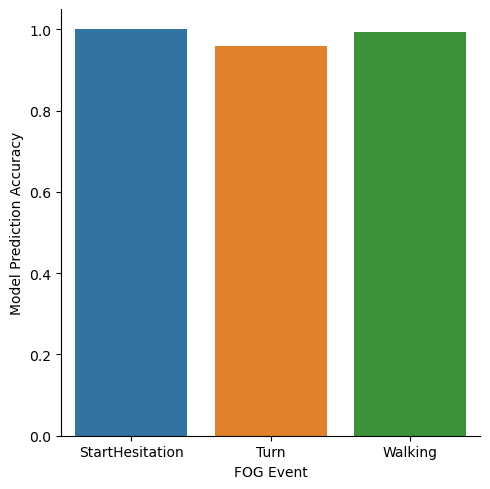

In [18]:
#  Exclusively Visualizing Accuracy
temp_df = pd.DataFrame({
    "FOG Event":['StartHesitation','Turn','Walking'],
    "Model Prediction Accuracy": rfc_metrics_df.loc["Accuracy"]
})

sns.catplot(data = temp_df, x = "FOG Event", y ="Model Prediction Accuracy", kind =  "bar")
plt.show()

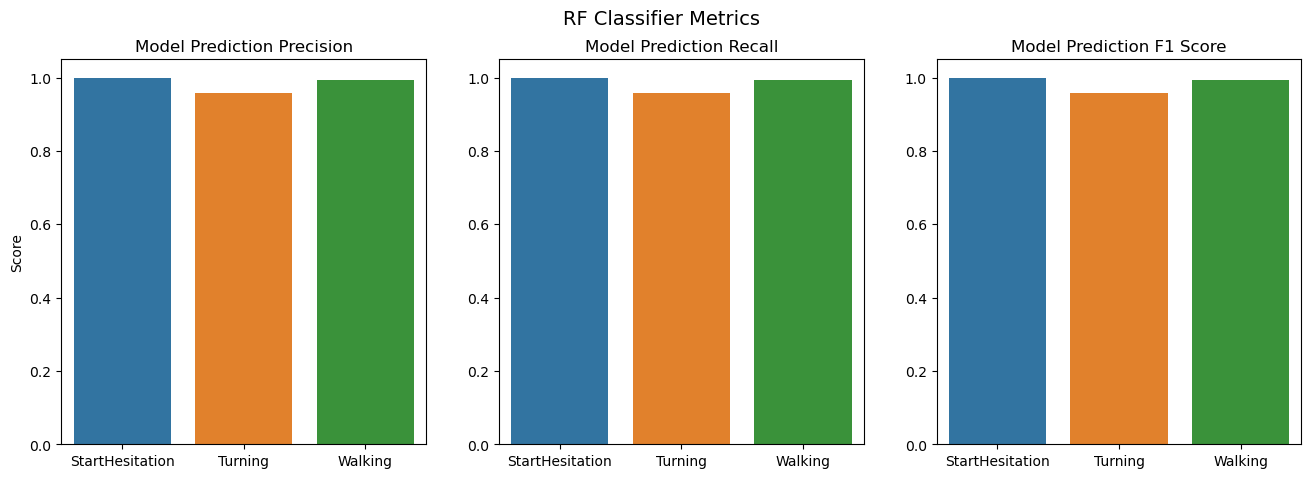

<Figure size 700x400 with 0 Axes>

In [19]:
# Visualizing Precision, Recall and F1 Score for each FoG Prediction\

plt.figure(figsize = (16, 5))
plt.suptitle("RF Classifier Metrics", fontsize=14)

plt.subplot(1,3,1)
sns.barplot(rfc_metrics_df.loc["Precision":])
plt.title('Model Prediction Precision')
plt.ylabel("Score")

plt.subplot(1,3,2)
sns.barplot(rfc_metrics_df.loc["Recall":])
plt.title('Model Prediction Recall')


plt.subplot(1,3,3)
sns.barplot(rfc_metrics_df.loc["F1 Score":])
plt.title('Model Prediction F1 Score')


plt.show()
plt.tight_layout()

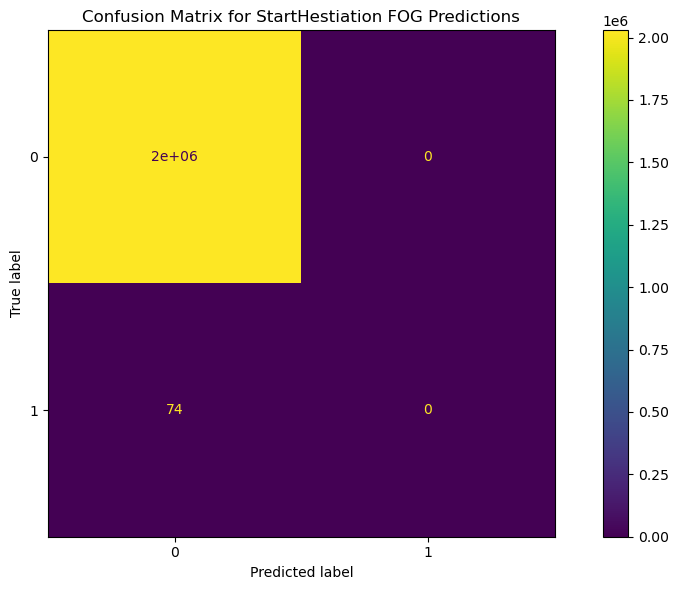

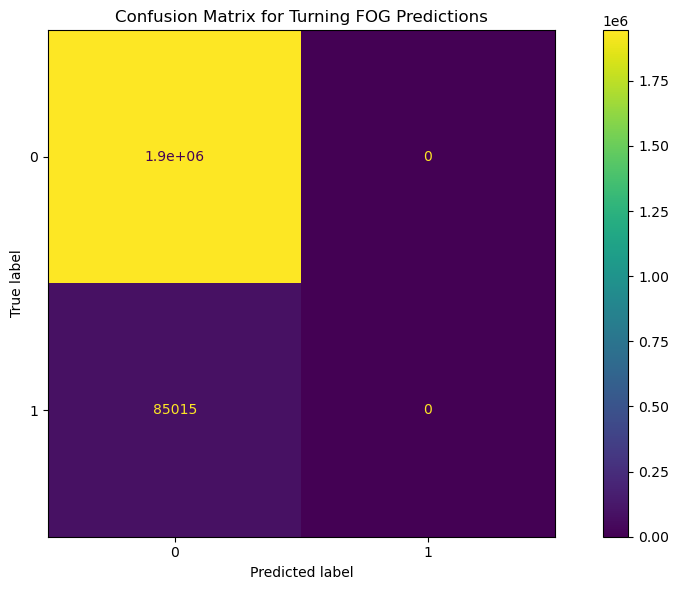

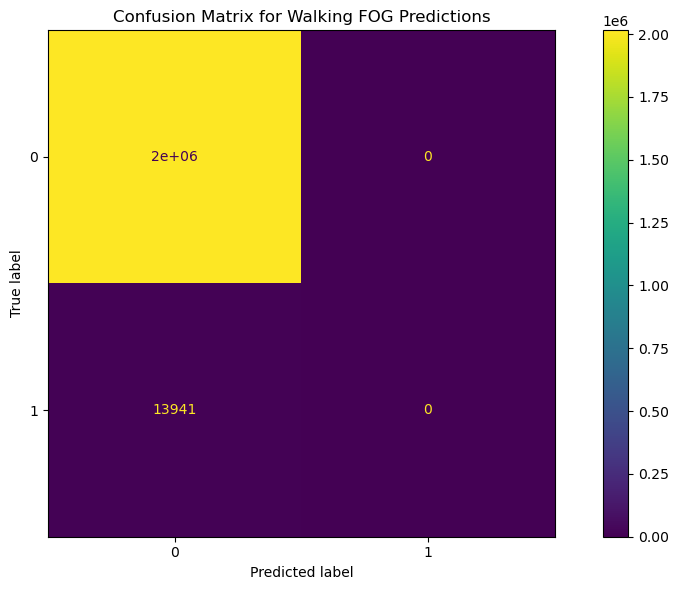

In [20]:
# Visualizing Confusion Matrix
rfc_ConMat = []
for i in range(3):
    rfc_ConMat.append(sklearn.metrics.confusion_matrix(y_true[i].values, y_pred[i]))

plt.rcParams["figure.figsize"] = [10.00, 6]

# StartHesitation
disp_Starthesitation = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix= rfc_ConMat[0])
disp_Starthesitation.plot()
plt.title('Confusion Matrix for StartHestiation FOG Predictions')
plt.tight_layout()


# Turning
disp_Turn = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix= rfc_ConMat[1])
disp_Turn.plot()
plt.title('Confusion Matrix for Turning FOG Predictions')
plt.tight_layout()

# Walking
disp_Walking = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix= rfc_ConMat[2])
disp_Walking.plot()
plt.title('Confusion Matrix for Walking FOG Predictions')
plt.tight_layout()

plt.show()

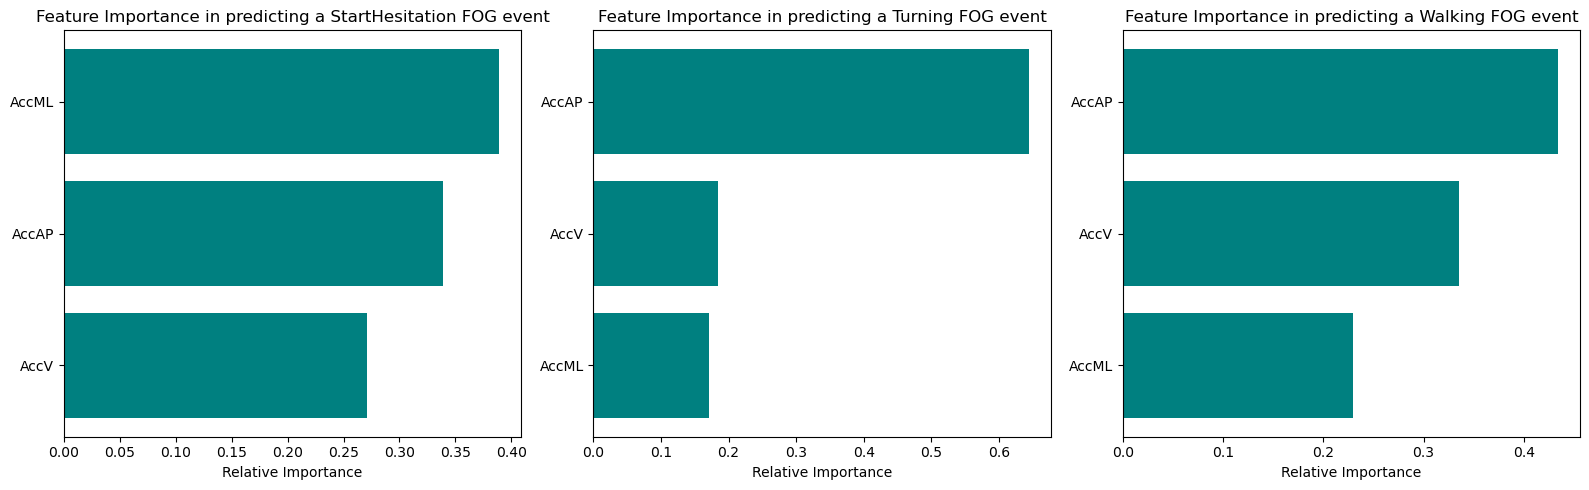

In [21]:
# Visualizing Feature Importance as determined by Random Forest
importances = [rfc_model[i].feature_importances_ for i in range(3)]
indicies = [np.argsort(importances[i]) for i in range(3)]
fog_events = ['StartHesitation','Turning','Walking']
plt.figure(figsize = (16, 5))
for x in range(3):
    title_text = "Feature Importance in predicting a " + fog_events[x] + " FOG event"
    plt.subplot(1,3,x+1)
    plt.title(title_text)
    plt.barh(range(len(indicies[x])), importances[x][indicies[x]], color = 'teal', align = 'center')
    plt.yticks(range(len(indicies[x])) ,[features[i] for i in indicies[x]])
    plt.xlabel("Relative Importance")    
    
plt.tight_layout()
plt.show()
                                     
                                    

### Down Sampling the data to deal with Misclassification due to Training set imbalance


In [22]:
# Down Sampling the data

targets = ["StartHesitation", "Turn", "Walking"]
down_sampled_dfs = []

# Downsampling the data for each FOG event
for target in targets:
    # Segmenting
    no_fog = train_df[train_df[target]== 0]
    fog = train_df[train_df[target]== 1]

    # Sampling the segments, NB: The largest sample number we can choose is lmited by the target variable with the smallest number of rows positive. I.E StartHesitation
    no_fog_sampled = resample(no_fog, replace = False, n_samples = 240, random_state = 42)
    fog_sampled = resample(fog, replace = False, n_samples = 240, random_state = 42)

    # Merging the sampled segments
    downsampled_df = pd.concat([no_fog_sampled, fog_sampled])
    down_sampled_dfs.append(downsampled_df)

# Concatenating into one final Down Sampled training Dataframe
ds_train_df = pd.concat(down_sampled_dfs)

#### Visualizing the distribution of the resampled dataset

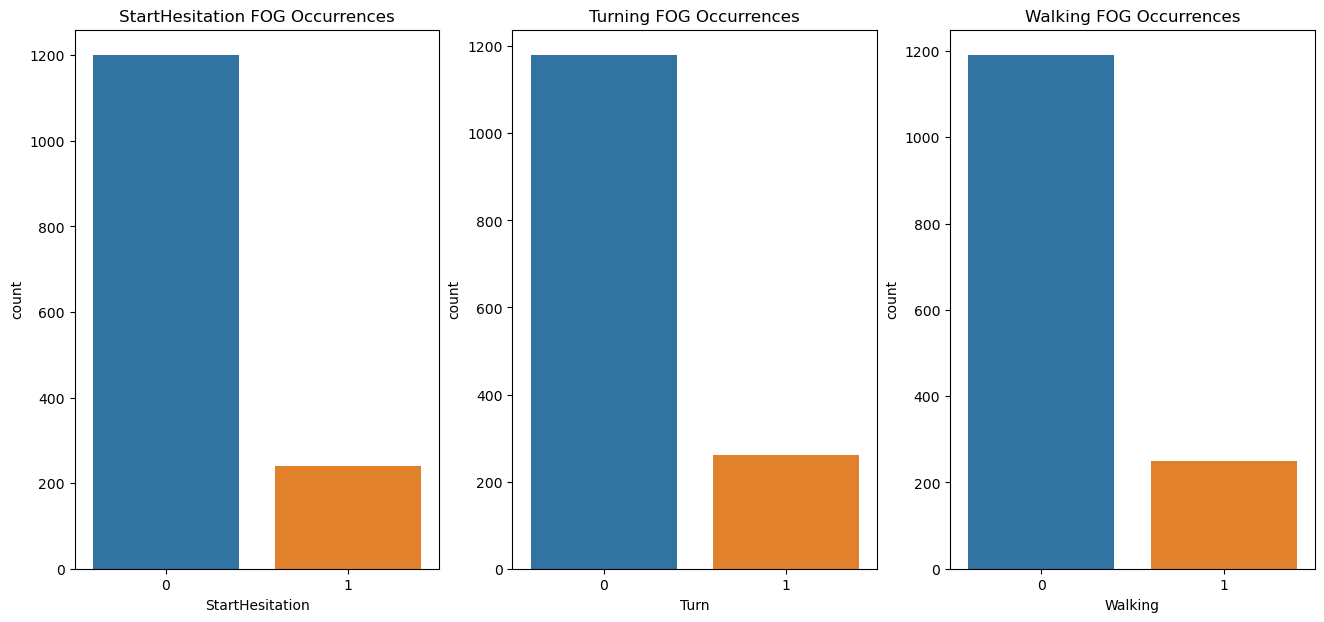

<Figure size 1000x600 with 0 Axes>

In [23]:
# Countplots of the 3 different FOG events
plt.figure(figsize = (16, 7))
plt.subplot(1,3,1)
sns.countplot(ds_train_df, x = "StartHesitation")
plt.title('StartHesitation FOG Occurrences')

plt.subplot(1,3,2)
sns.countplot(ds_train_df, x = "Turn")
plt.title('Turning FOG Occurrences')

plt.subplot(1,3,3)
sns.countplot(ds_train_df, x = "Walking")
plt.title('Walking FOG Occurrences')
plt.show()
plt.tight_layout()

#### Re-running the RF Classification Model

In [24]:
# RANDOM FOREST CLASSIFICATION
# Defining the Training Data set and Validation Data set (Traditionally called Test set)
features = ['AccV', 'AccML', 'AccAP']

X = ds_train_df[features]
y = [ds_train_df['StartHesitation'],ds_train_df['Turn'],ds_train_df['Walking']]


# Building all the Ransvm_accuracy Forest models with the various target data in the order outlined in y
rfc_model = []
y_pred = []
y_true = []
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y[i], test_size = 0.3)
    model = RandomForestClassifier(n_estimators = 100,
                                        criterion = "gini",
                                        max_depth = 5,
                                        random_state = 5)
    rfc_model.append(model)
    
    # Fitting the model 
    rfc_model[i].fit(X_train, y_train)
    
    # Testing the model on the validation set
    y_prediction = rfc_model[i].predict(X_test)
    y_pred.append(y_prediction)
    y_true.append(y_test)
  
    
# Assessing Model Accuracy
rfc2_accuracy = [sklearn.metrics.accuracy_score(y_true[i].values, y_pred[i]) for i in range(3)]
rfc2_precision = [sklearn.metrics.precision_score(y_true[i].values, y_pred[i], average = 'micro', zero_division = 0) for i in range(3)]
rfc2_recall = [sklearn.metrics.recall_score(y_true[i].values, y_pred[i], average = 'micro', zero_division= 0) for i in range(3)]
rfc2_f1score = [sklearn.metrics.f1_score(y_true[i].values, y_pred[i], average = 'micro', zero_division= 0) for i in range(3)]
rfc2_metrics = [rfc2_accuracy,rfc2_precision, rfc2_recall, rfc2_f1score]


# Model Metrics Dataframe
rfc2_metrics_df = pd.DataFrame(
    data = rfc2_metrics, 
    columns = ["StartHesitation", "Turning", "Walking"],
    index = ["Accuracy", "Precision", "Recall", "F1 Score"]
)

rfc2_metrics_df
    

,StartHesitation,Turning,Walking
Accuracy,0.900463,0.810185,0.824074
Precision,0.900463,0.810185,0.824074
Recall,0.900463,0.810185,0.824074
F1 Score,0.900463,0.810185,0.824074


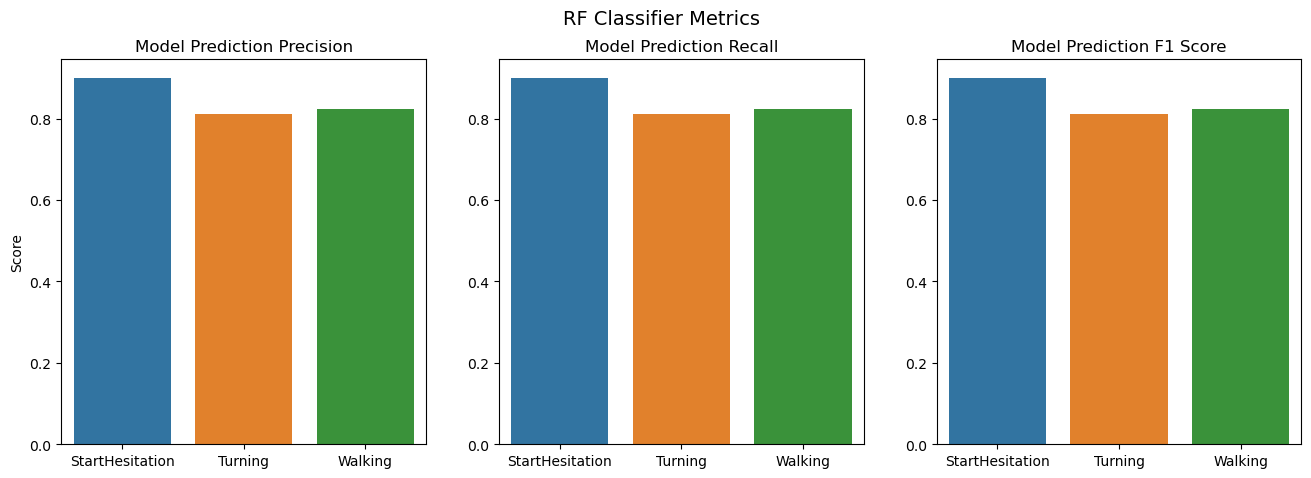

<Figure size 1000x600 with 0 Axes>

In [25]:
# Visualizing Precision, Recall and F1 Score for each FoG Prediction

plt.figure(figsize = (16, 5))
plt.suptitle("RF Classifier Metrics", fontsize=14)

plt.subplot(1,3,1)
sns.barplot(rfc2_metrics_df.loc["Precision":])
plt.title('Model Prediction Precision')
plt.ylabel("Score")

plt.subplot(1,3,2)
sns.barplot(rfc2_metrics_df.loc["Recall":])
plt.title('Model Prediction Recall')


plt.subplot(1,3,3)
sns.barplot(rfc2_metrics_df.loc["F1 Score":])
plt.title('Model Prediction F1 Score')


plt.show()
plt.tight_layout()

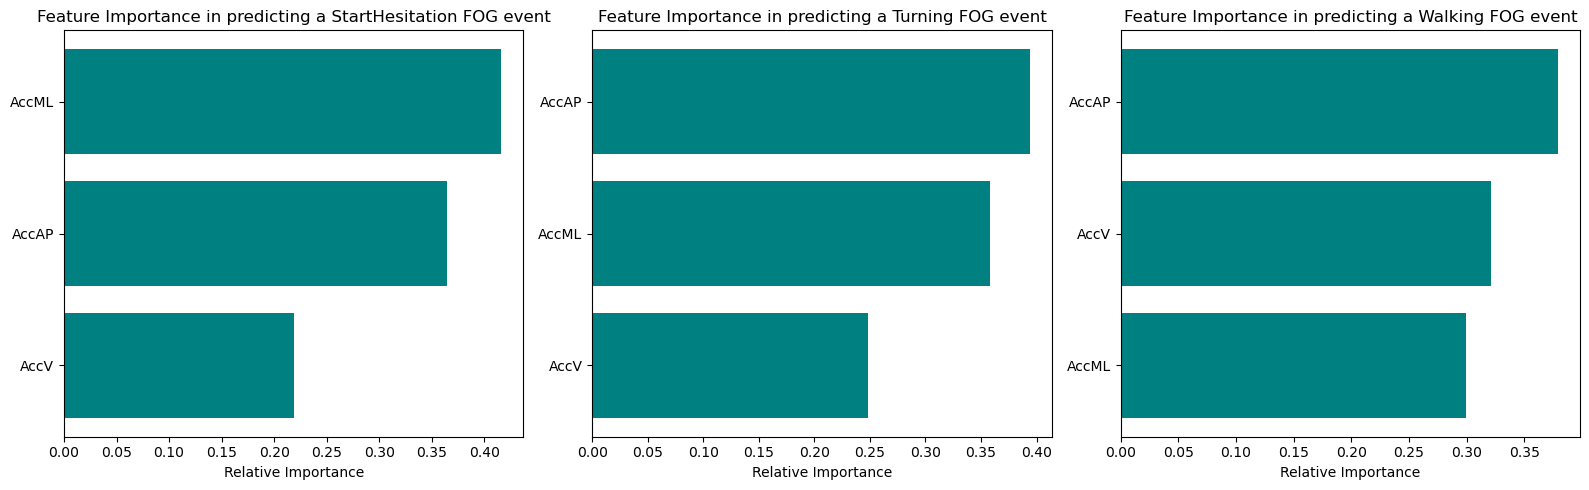

In [26]:
# Visualizing Feature Importance as determined by Random Forest
importances = [rfc_model[i].feature_importances_ for i in range(3)]
indicies = [np.argsort(importances[i]) for i in range(3)]
fog_events = ['StartHesitation','Turning','Walking']
plt.figure(figsize = (16, 5))
for x in range(3):
    title_text = "Feature Importance in predicting a " + fog_events[x] + " FOG event"
    plt.subplot(1,3,x+1)
    plt.title(title_text)
    plt.barh(range(len(indicies[x])), importances[x][indicies[x]], color = 'teal', align = 'center')
    plt.yticks(range(len(indicies[x])) ,[features[i] for i in indicies[x]])
    plt.xlabel("Relative Importance")    
    
plt.tight_layout()
plt.show()
                                     
                                    

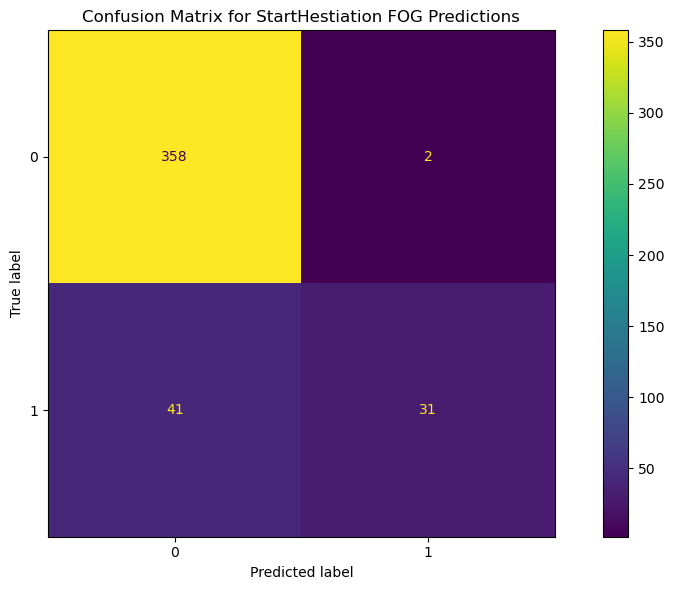

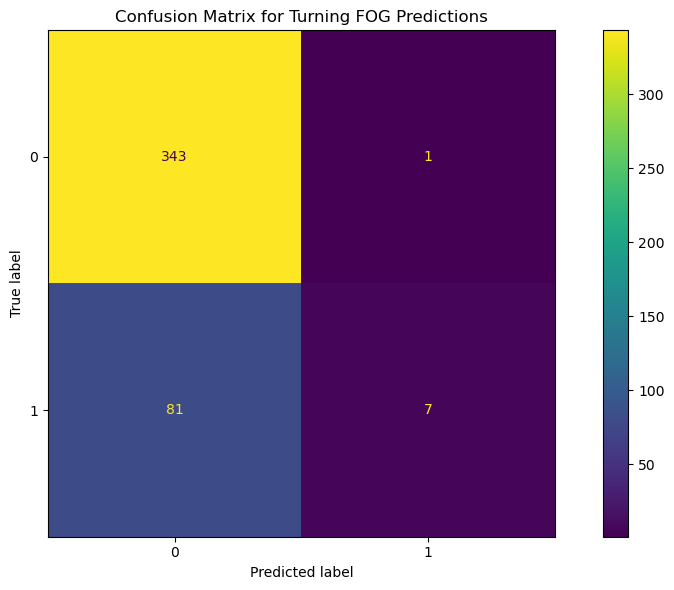

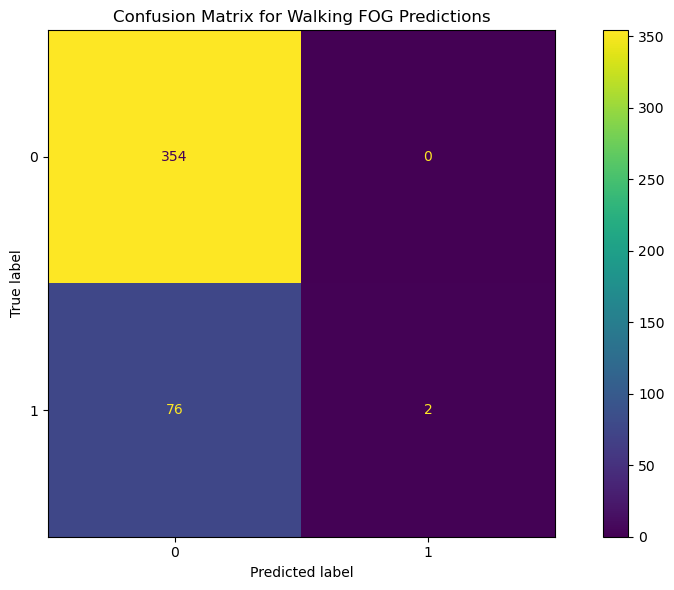

In [27]:
# Visualizing Confusion Matrix
rfc_ConMat = []
for i in range(3):
    rfc_ConMat.append(sklearn.metrics.confusion_matrix(y_true[i].values, y_pred[i]))

plt.rcParams["figure.figsize"] = [10.00, 6]

# StartHesitation
disp_Starthesitation = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix= rfc_ConMat[0])
disp_Starthesitation.plot()
plt.title('Confusion Matrix for StartHestiation FOG Predictions')
plt.tight_layout()


# Turning
disp_Turn = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix= rfc_ConMat[1])
disp_Turn.plot()
plt.title('Confusion Matrix for Turning FOG Predictions')
plt.tight_layout()

# Walking
disp_Walking = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix= rfc_ConMat[2])
disp_Walking.plot()
plt.title('Confusion Matrix for Walking FOG Predictions')
plt.tight_layout()

plt.show()

## Support Vector Machines



In [28]:
# SUPPORT VECTOR MACHINE CLASSIFICATION

# Down Sampling the data
# Owing to its mathematical construct, SVM is a great machine learning technique for relatively smaller datasets than it is on huge datasets.
# With such a huge dataset, it will take a very long time to optimize parameters with Cross Validation. Therefore we downsample to a more manageable amount to train the model.

targets = ["StartHesitation", "Turn", "Walking"]
down_sampled_dfs = []

# Downsampling the data for each FOG event
for target in targets:
    # Segmenting
    no_fog = train_df[train_df[target]== 0]
    fog = train_df[train_df[target]== 1]

    # Sampling the segments, NB: The highest sample number we can make is lmited by the target variable with the smallest number of rows positive. I.E StartHesitation
    no_fog_sampled = resample(no_fog, replace = False, n_samples = 240, random_state = 42)
    fog_sampled = resample(fog, replace = False, n_samples = 240, random_state = 42)

    # Merging the sampled segments
    downsampled_df = pd.concat([no_fog_sampled, fog_sampled])
    down_sampled_dfs.append(downsampled_df)

# Concatenating into one final Dataframe
svm_train_df = pd.concat(down_sampled_dfs)

In [29]:
# SVM CLASSIFICATION
# Defining the Training Data set and Validation Data set (Traditionally called Test set)
features = ['AccV', 'AccML', 'AccAP']

# Utilizing the downsampled data
X = ds_train_df[features]
y = [ds_train_df['StartHesitation'],ds_train_df['Turn'],ds_train_df['Walking']]


# Building the SVM models with the various target data in the order outlined in y
svm_model = []
y_pred = []
y_true = []
perm_importances = []
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y[i], test_size = 0.3)
    model = SVC(random_state = 42)
    
    svm_model.append(model)
    
    # The Radial Basis Function is here employed  by default within the SVM algorithm and assumes the feature data is centered amd scale.
    # Therefore we first perform centering and scaling on the feature data for both the training and validation set
    X_train_scaled = scale(X_train)
    X_test_scaled = scale(X_test)

    # Fitting the model 
    svm_model[i].fit(X_train_scaled, y_train)
    
    # Testing the model on the validation set
    y_prediction = svm_model[i].predict(X_test_scaled)
    
    # Logging predictive feature importance
    perm_importances.append(permutation_importance(svm_model[i], X_test_scaled, y_test))
    
    y_pred.append(y_prediction)
    y_true.append(y_test)
  
    

### Model Evaluation (Support Vector Machines)

In [30]:
# Assessing Model Accuracy
svm_accuracy = [sklearn.metrics.accuracy_score(y_true[i].values, y_pred[i]) for i in range(3)]
svm_precision = [sklearn.metrics.precision_score(y_true[i].values, y_pred[i], average = 'micro', zero_division = 0) for i in range(3)]
svm_recall = [sklearn.metrics.recall_score(y_true[i].values, y_pred[i], average = 'micro', zero_division = 0) for i in range(3)]
svm_f1score = [sklearn.metrics.f1_score(y_true[i].values, y_pred[i], average = 'micro', zero_division = 0) for i in range(3)]
svm_metrics = [svm_accuracy, svm_precision, svm_recall, svm_f1score]

# Model Metrics Dataframe
svm_metrics_df = pd.DataFrame(
    data = svm_metrics, 
    columns = ["StartHesitation", "Turning", "Walking"],
    index = ["Accuracy", "Precision", "Recall", "F1 Score"]
)

svm_metrics_df

,StartHesitation,Turning,Walking
Accuracy,0.837963,0.81713,0.835648
Precision,0.837963,0.81713,0.835648
Recall,0.837963,0.81713,0.835648
F1 Score,0.837963,0.81713,0.835648


### Visualizing Key Classification Metrics

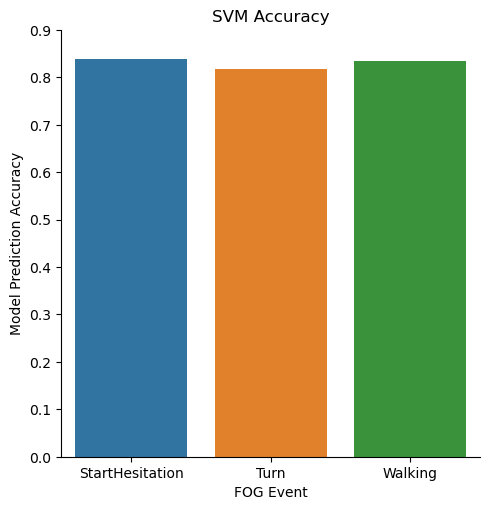

In [31]:
# Visualzing Accuracy
temp_df = pd.DataFrame({
    "FOG Event":['StartHesitation','Turn','Walking'],
    "Model Prediction Accuracy": svm_metrics_df.loc["Accuracy"]
})

sns.catplot(data = temp_df, x = "FOG Event", y ="Model Prediction Accuracy", kind =  "bar")
plt.yticks(np.arange(0, 1, step=0.1))
plt.title("SVM Accuracy")
plt.show()

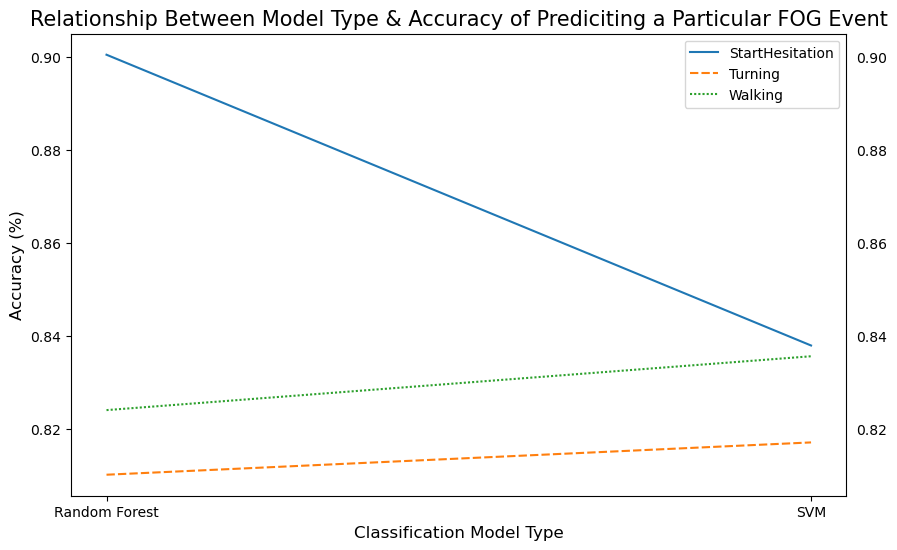

<Figure size 1200x600 with 0 Axes>

In [32]:
# Intuitively Comparing the accuracy of the RF and SVM Classifiers
RF_SVM_accuracy = pd.concat([rfc2_metrics_df.loc["Accuracy"], svm_metrics_df.loc["Accuracy"]] )

rfc_accuracy =  np.array(rfc2_metrics_df.loc["Accuracy"]).reshape(1,3)
svm_accuracy =  np.array(svm_metrics_df.loc["Accuracy"]).reshape(1,3)


accuracy_comp = pd.DataFrame(
    data = np.vstack((rfc_accuracy, svm_accuracy)),
    columns = ["StartHesitation", "Turning", "Walking"],
    index = ["Random Forest", "SVM"]
)
accuracy_comp['model'] = accuracy_comp.index
sns.lineplot(data = accuracy_comp)
plt.xlabel("Classification Model Type", size = 12)
plt.ylabel("Accuracy (%)", size = 12)
plt.title("Relationship Between Model Type & Accuracy of Prediciting a Particular FOG Event", size = 15)

plt.rcParams["figure.figsize"] = [12, 6]
plt.tick_params(axis = 'both', labelright=True)
plt.show()
plt.tight_layout()

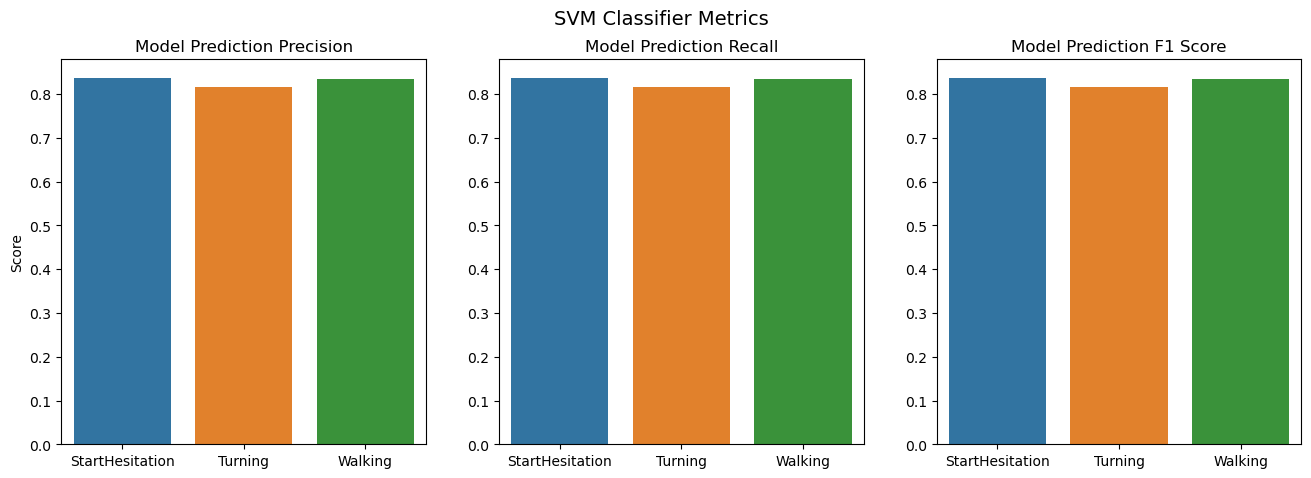

<Figure size 1200x600 with 0 Axes>

In [33]:
# Visualizing Precision, Recall and F1 Score for each FoG Prediction

plt.figure(figsize = (16, 5))
plt.suptitle("SVM Classifier Metrics", fontsize=14)

plt.subplot(1,3,1)
sns.barplot(svm_metrics_df.loc["Precision":])
plt.title('Model Prediction Precision')
plt.ylabel("Score")

plt.subplot(1,3,2)
sns.barplot(svm_metrics_df.loc["Recall":])
plt.title('Model Prediction Recall')


plt.subplot(1,3,3)
sns.barplot(svm_metrics_df.loc["F1 Score":])
plt.title('Model Prediction F1 Score')


plt.show()
plt.tight_layout()

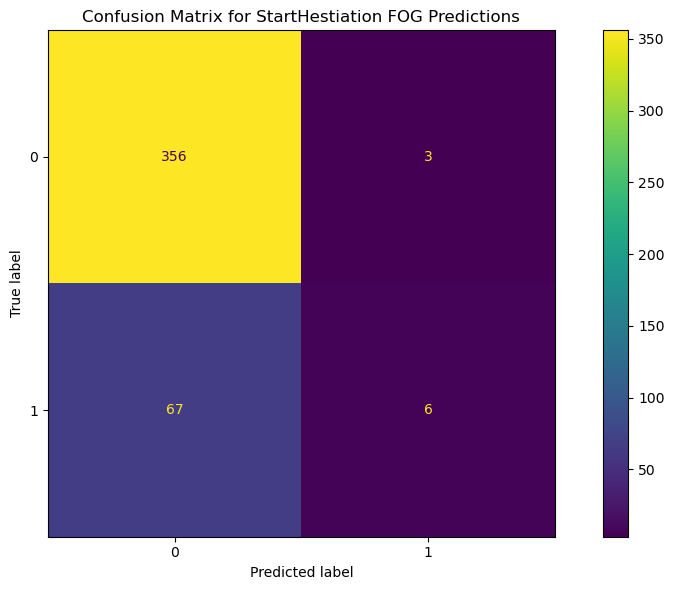

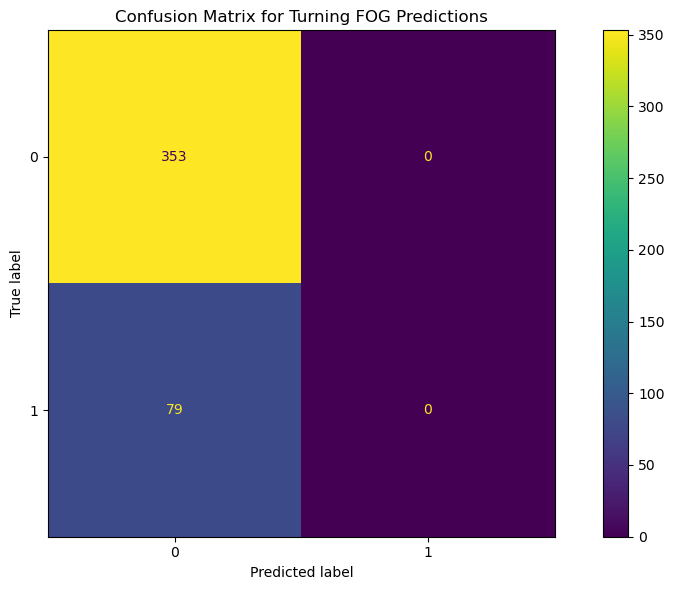

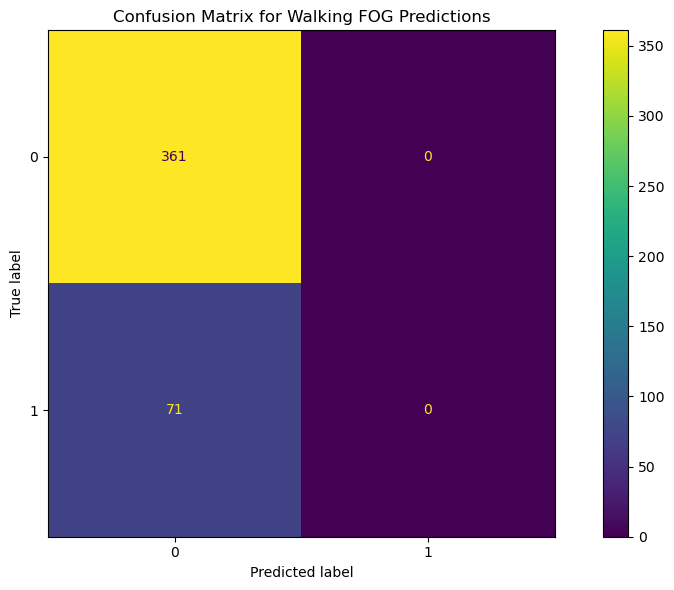

In [34]:
# Visualizing Confusion Matrix
svm_ConMat = []
for i in range(3):
    svm_ConMat.append(sklearn.metrics.confusion_matrix(y_true[i].values, y_pred[i]))

plt.rcParams["figure.figsize"] = [10.00, 6]

# StartHesitation
disp_Starthesitation = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix= svm_ConMat[0])
disp_Starthesitation.plot()
plt.title('Confusion Matrix for StartHestiation FOG Predictions')
plt.tight_layout()


# Turning
disp_Turn = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix= svm_ConMat[1])
disp_Turn.plot()
plt.title('Confusion Matrix for Turning FOG Predictions')
plt.tight_layout()

# Walking
disp_Walking = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix= svm_ConMat[2])
disp_Walking.plot()
plt.title('Confusion Matrix for Walking FOG Predictions')
plt.tight_layout()

plt.show()

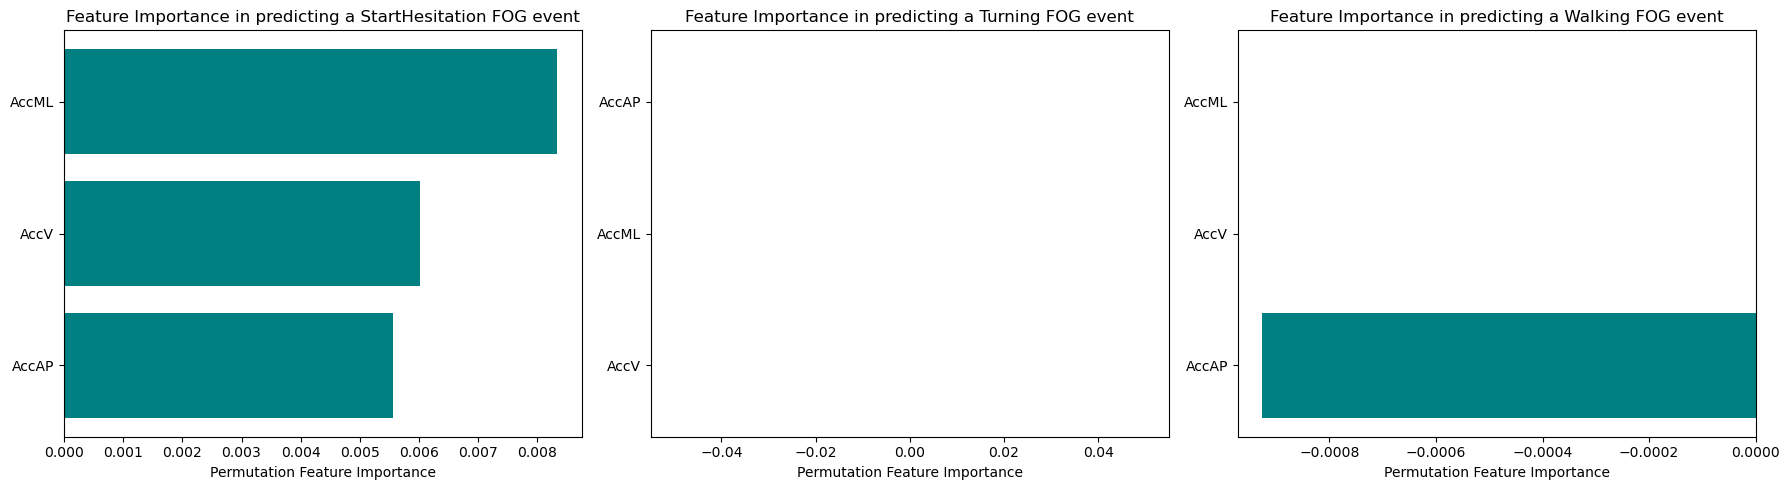

In [35]:
# Visualizing Feature Importance as determined by SVM

fog_events = ['StartHesitation','Turning','Walking']
features = np.array(features)
sorted_idx = [perm_importances[i].importances_mean.argsort() for i in range(3)]

plt.figure(figsize = (18, 5))
for x in range(3):
    title_text = "Feature Importance in predicting a " + fog_events[x] + " FOG event"
    plt.subplot(1,3,x+1)
    plt.title(title_text)
#     plt.barh(range(len(sorted_idx[x])), perm_importances[x].importances_mean[sorted_idx[x]], color = 'teal', align = 'center')
    plt.barh(features[sorted_idx[x]], perm_importances[x].importances_mean[sorted_idx[x]], color = 'teal')
    plt.yticks(range(len(sorted_idx[x])) ,[features[i] for i in sorted_idx[x]])
    plt.xlabel("Permutation Feature Importance")    
    
plt.tight_layout()
plt.show()


## Comparing Model Performances

In [36]:

comp_metrics = pd.concat([rfc2_metrics_df,svm_metrics_df])

labels = [
    ("Random Forest-" * 4).split('-')[:-1] + ("SVM-" * 4).split('-')[:-1],
    ["Accuracy", "Precision", "Recall", "F1 Score"] * 2
] 

tuples = list(zip(*labels))
index = pd.MultiIndex.from_tuples(tuples, names=["Machine Learning Algorithm", "Classification Metric"])

# Create dataframe
metrics_final = pd.DataFrame(
   comp_metrics.values,
   index = index,
   columns=["StartHesitation", "Turning", "Walking"]
)


metrics_final



StartHesitation   Turning  \
Machine Learning Algorithm Classification Metric                              
Random Forest              Accuracy                      0.900463  0.810185   
                           Precision                     0.900463  0.810185   
                           Recall                        0.900463  0.810185   
                           F1 Score                      0.900463  0.810185   
SVM                        Accuracy                      0.837963  0.817130   
                           Precision                     0.837963  0.817130   
                           Recall                        0.837963  0.817130   
                           F1 Score                      0.837963  0.817130   

                                                   Walking  
Machine Learning Algorithm Classification Metric            
Random Forest              Accuracy               0.824074  
                           Precision              0.824074  
                           Recall                 0.824074  
                           F1 Score               0.824074  
SVM                        Accuracy               0.835648  
                           Precision              0.835648  
                           Recall                 0.835648  
                           F1 Score               0.835648

## Model Selection (Cross Validation Accuracy Assessment)

#### Performing Model Optimization & Selection via K-Fold Cross Validation metrics

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#### Random Forest Cross Validation Scoring

In [38]:
# Setting up the Random Forest Cross Val Score model
features = ['AccV', 'AccML', 'AccAP']

# Defining the x & y
X = ds_train_df[features]
y = [ds_train_df['StartHesitation'],ds_train_df['Turn'],ds_train_df['Walking']]

k = 5
kf = KFold(n_splits=k, random_state=None)
rfc_model = RandomForestClassifier(n_estimators = 100,
                                        criterion = "gini",
                                        max_depth = 5,
                                        random_state = 5)
 
result_RF = [cross_val_score(rfc_model , X, y[i], cv = kf).mean() for i in range(3)]

In [39]:
print("Avg Cross Val Score: {}".format(result_RF))
# Avg Cross Val Score: [0.8645833333333334, 0.8208333333333332, 0.8125]

Avg Cross Val Score: [0.8645833333333334, 0.8208333333333332, 0.8125]


#### SVM Cross Validation Scoring

In [40]:
# Setting up the SVM cross val score model
features = ['AccV', 'AccML', 'AccAP']

# Defining the downsampled x & y (Previously defined)
X = svm_train_df[features]
y = [svm_train_df['StartHesitation'],svm_train_df['Turn'],svm_train_df['Walking']]

k = 5
kf = KFold(n_splits=k, random_state=None)
svm_model = SVC(random_state = 42)
 
result_SVM = [cross_val_score(svm_model , X, y[i], cv = kf).mean() for i in range(3)]

In [41]:
print("Avg Cross Val Score: {}".format(result_SVM))
# Avg Cross Val Score: [0.8333333333333334, 0.81875, 0.826388888888889]  

Avg Cross Val Score: [0.8333333333333334, 0.81875, 0.826388888888889]
